# Introducción a la Programación en JULIA
## Notebook 12

Mauricio Tejada

ILADES - Universidad Alberto Hurtado

## Contenidos

- [Aplicaciones III](#12.-Aplicaciones-III)
    - [Linealización de una Función](#12.1-Linealización-de-una-Función)
    - [Esperanza Matemática](#12.2-Esperanza-Matemática)
    - [Duopolio de Cournot](#12.3-Modelo-de-Duopolio-de-Cournot)
    - [Estimación por Máximo Verosimilitud](#12.4-Estimación-por-Máximo-Verosimilitud)
    - [El Problema de Maximización del Consumidor](#12.5-El-Problema-de-Maximización-del-Consumidor)
    

## 12. Aplicaciones III

### 12.1 Linealización de una Función

Calculemos la aproximación de Taylor de primer orden de la función $$f (x, y) = xe^{-x^2-y^2}$$ alrededor del punto (1,1), esto es: $$f(x,y) ≈ f(1,1)+fx(1,1)(x−1)+fy(1,1)(y−1)$$

El ejercicio consisten entonces en evaluar la función en el punto de aproximación $f(1,1)$ y encontrar las derivadas parciales con respecto a $x$ e $y$, y evaluarlas también en el punto de aproximación: $f_x(1,1)$ y $f_y(1,1)$.

El primer paso es definir la función:

In [36]:
fxy(x) = x[1]*exp(-x[1]^2-x[2]^2)

fxy (generic function with 1 method)

Evaluamos la función en el punto $(1,1)$ y calculamos las derivadas parciales evaluada en ese mismo punto:

In [37]:
using Calculus
using Plots
pyplot()

Plots.PyPlotBackend()

In [38]:
fc = fxy([1, 1])
df = Calculus.gradient(fxy,[1, 1])
fx = df[1]
fy = df[2]

fxyaprox(x) = fc - fx - fy + fx*x[1] + fy*x[2]

fxyaprox (generic function with 1 method)

In [39]:
x=[1.1, 1.1]
fo = fxy(x)
fa = fxyaprox(x)
println("Función Original: $fo")
println("Función Aproximada: $fa")

Función Original: 0.09781377920532494
Función Aproximada: 0.09473469826750897


Así luce la aproximación:

In [40]:
x = collect(range(0.5, stop = 1.5, step = 0.1))
n = length(x)

forig = zeros(n,n)
faprox = zeros(n,n)
X = zeros(n,n)

for i in 1:n, j in 1:n
    forig[i,j] = fxy([x[i], x[j]])
    faprox[i,j] = fxyaprox([x[i], x[j]])
    X[i,j] = x[j]
end

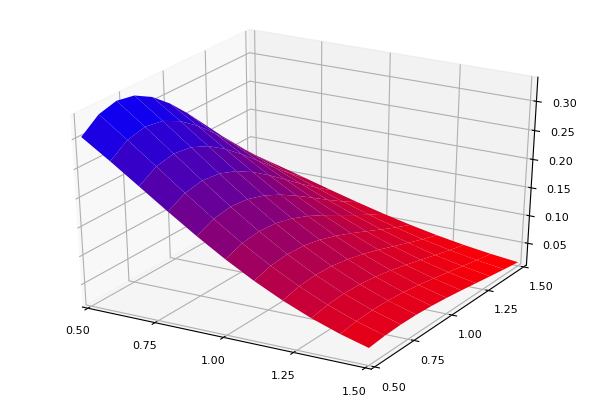

In [41]:
plot(x, x, forig, st=:surface, legend=false, color=cgrad([:red,:blue]), grid = true)

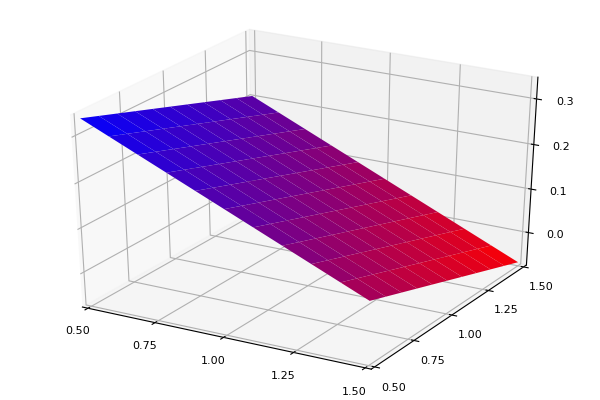

In [42]:
plot(x, x, faprox, st=:surface, legend=false, color=cgrad([:red,:blue]), grid = true)

### 12.2 Esperanza Matemática

Calculemos la esperanza matemática de una variable aleatoria normal $x$: $$E(x) = \int^{\infty}_{-\infty} x f(x)dx$$ donde $f(x)$ es la función de densidad normal. Para esto escribimos la función recordando que:

$$f(x) = \frac{1}{\sigma \sqrt {2\pi}}e^{- \frac{\left( x - \mu  \right)^2}{2 \sigma^2} }$$

In [43]:
using QuadGK

In [44]:
function integrando(x,mu,sigma)

    fx = (1/(sigma*sqrt(2*π)))*exp(-(x-mu)^2/(2*sigma^2))
    return x*fx

end

integrando (generic function with 1 method)

In [45]:
Ex = quadgk(x->integrando(x,3,2),-Inf,Inf)[1]

3.0000000000000036

Alternativamente podemos usar el paquete **Distributions** que implementa varias distribuciones de probabilidad tanto continuas como discretas. En este ejemplo usaremos la distribución normal y la sintaxis es:

`nombre_distribucion = Normal(media, varianza)`

Este comando crea un objeto del tipo distribución al cual se le pueden aplicar varias funciones provistas en el paquete. Algunas de estas funciones son:

- `pdf(nombre_distribucion,x)`: Función de densidad.
- `cdf(nombre_distribucion,x)`: Función de Distribución Acumulada
- `rand(nombre_distribucion, numero_elementos)`: Generados de números aleatorios.
- `quantile(nombre_distribucion, percentiles)`: Percentiles de la distribución.

La lista de distribuciones que Distributions tiene implementadas y todas las opciones para caracterizar dichas distribuciones puede verse en la [documentación](https://juliastats.github.io/Distributions.jl/stable/). 

In [46]:
using Distributions

In [47]:
function integrando2(x,mu,sigma)

    d = Normal(mu, sigma)
    return x*pdf(d,x)

end

integrando2 (generic function with 1 method)

In [48]:
Ex = quadgk(x->integrando2(x,3,2),-Inf,Inf)[1]

3.0000000000000036

In [49]:
d = Normal(3, 2)
mean(d)

3.0

### 12.3 Modelo de Duopolio de Cournot

*Aplicación tomada de Miranda y Fackler (2002), Capítulo 3.*

Suponga que la demanda de mercado es provista por dos empresas 1 y 2. La función de demanda es:

$$P(q) = q^{1/\eta}$$

con $q=q_1+q_2$. Laq función de costos de la empresa $i=1,2$ es:

$$C_i(q_i) = 0.5c_iq^2_i$$

Con esto es posible escribir la función de beneficios de la empresa $i$ como:

$$\pi(q_1,q_2) = P(q_1+q_2)q_i - C_i(q_i)$$

Reemplazando tenemos:

$$\pi(q_1,q_2) = (q_1+q_2)^{1/\eta}q_i - 0.5c_iq^2_i$$

Cada firma busca maximizar su beneficio eligiendo la cantidad que produce y tomando como dada la decisión de la otra empresa.

Las condiciones de primer orden son:

$$(q_1+q_2)^{-1/\eta} - (1/\eta)(q_1+q_2)^{-1/\eta-1} - c_iq_i = 0, \ \ \ i=1,2$$

Note que el equilibrio está caracterizado por la solución del sistema de dos ecuaciones no lineales anterior.

Para resolver el modelo escribimos la siguiente función:

In [50]:
function cournot(q,c,eta)

    neq = length(q)
    fval = zeros(neq,1)

    q1 = q[1]
    q2 = q[2]

    c1 = c[1]
    c2 = c[2]

    fval[1] = (q1+q2)^(-1/eta) - (1/eta)*((q1+q2)^(-(1/eta)-1))*q1 - c1*q1
    fval[2] = (q1+q2)^(-1/eta) - (1/eta)*((q1+q2)^(-(1/eta)-1))*q2 - c2*q2
    
    return fval

end

cournot (generic function with 1 method)

Definimos los parámetros:

In [51]:
c = [0.6, 0.6]
eta = 1.2;

Usamos `nlsolve` para encontrar la solución:

In [52]:
using NLsolve

In [53]:
q0 = [0.2, 0.2]
sol_cournot = nlsolve(x -> cournot(x,c,eta), q0, inplace = false);

In [54]:
qstar = sol_cournot.zero

2-element Array{Float64,1}:
 0.7186126263887692
 0.7186126263887692

La idea de escribir la función dejando `c` y `eta` como inputs permite simular la solución bajo distintos niveles de costos y de la elasticidad de la demanda.

### 12.4 Estimación por Máximo Verosimilitud 

Suponga que buscamos estimar el siguiente modelo de regresión lineal:

$$y_i = \beta_0 + \beta_1 x_{1i}+ \beta_2 x_{2i} + u_i$$

por el método de máximo verosimilitud. Para ello suponemos que:

$$u_i \sim N(0,\sigma^2)$$ 

Usaremos los datos que generamos para la aplicación sobre MCO.

In [55]:
using DelimitedFiles
using Distributions
using Optim

In [56]:
impdata = readdlm("DatosMCO.txt", ',')
N, K = size(impdata)
y = impdata[:,1]
X1 = impdata[:,2]
X2 = impdata[:,3]

X = [X1 X2]

100×2 Array{Float64,2}:
  2.0753    3.6808
  4.6678    0.22394
 -3.5177    2.2002
  2.7243    0.91094
  1.6375    2.607
 -1.6154    0.79935
  0.13282   2.9799
  1.6852    3.4787
  8.1568    5.4238
  6.5389    1.6118
 -1.6998   -2.2767
  7.0698    0.32082
  2.4508    4.7092
  ⋮        
  1.4313    3.3203
 -1.3317    1.8643
 -1.2959    1.6096
  1.2097    1.5648
  2.4445    1.3938
  6.171     2.0461
 -0.33378   2.1026
  1.3747    3.6521
  0.83501   5.054
 -2.866     2.9338
  0.12207   1.5806
 -2.5894    3.2504

La función de verosimilitud se define como:

$$L(y,x1,x2|\beta_0,\beta_1,\beta_2,\sigma) = \prod^n_{i=1} f(u_i)$$

donde $f(u_i)$ es la función de densidad normal. Tomando logaritmos:

$$\ln L(y,x1,x2|\beta_0,\beta_1,\beta_2,\sigma) = \sum^n_{i=1} \ln f(u_i)$$

El objetivo es maximizar $$\ln L(y,x1,x2|\beta_0,\beta_1,\beta_2,\sigma)$$ eligiendo los parámetros $(\beta_0,\beta_1,\beta_2,\sigma)$.

El primer paso es escribir la función de verosimilitud y para ellos haremos uso del paquete **Distributions**. 

Maximizamos la función de verosimilitud:

In [57]:
function loglike(par,y,X)

    beta0 = par[1]
    beta1 = par[2]
    beta2 = par[3]
    sig   = exp(par[4])

    N = length(y)

    L = zeros(N)
    
    d = Normal(0,sig)

    for i in 1:N
        ui = y[i] - beta0 - beta1*X[i,1] - beta2*X[i,2]
        L[i] = pdf(d,ui)
    end
    # L = [pdf(d, y[i] - beta0 - beta1*X[i,1] - beta2*X[i,2]) for i in 1:N]    # Alternativa

    return -sum(log.(L))

end

loglike (generic function with 1 method)

In [58]:
par0 = [2, 0.1, 0.1, log(2)]
res_mv = optimize(x -> loglike(x,y,X), par0, LBFGS());

In [59]:
params = res_mv.minimizer

4-element Array{Float64,1}:
  2.9913098845675625
  0.563963507081578
  0.8019684022812208
 -0.016972951804659586

Los datos fueron generados bajo el siguiente modelo:

$$y_i = 3 + 0.5X_{1i} + 0.9X_{2i} + u_i$$

donde $u_i \sim N(0,1)$.

Finalmente, la desviación estándar será: 

In [60]:
sig = exp(params[4])

0.9831702772569789

### 12.5 El Problema de Maximización del Consumidor

Suponga que un consumidor busca maximizar la siguiente función de utilidad:

$$U(x_1,x_2,...,x_n) = \sum^{n}_{i=1}x^{\alpha_i}_i$$

con $\sum^{n}_{i=1}\alpha_i = 1$. Sujeto a la restricción presupuestaria:

$$p_1x_1 + p_2x_2 + ... + p_nx_n \leq m$$ 

y las restricciones de no negatividad:

$$x_i \geq 0 $$

con $m$ es ingreso y $p_i$ el precio del bien $i$.

Maximicemos la utilidad bajo el supuesto que existen 4 bienes. Definimos los parámetros del modelo:

In [61]:
using JuMP
using Ipopt

In [62]:
modelo_consumidor = Model(Ipopt.Optimizer);

Ahora definimos los parámetros de optimización:

In [63]:
alpha = [0.2, 0.4, 0.1, 0.3]
p = [2, 3, 4, 5]
m = 100;

Declaramos las variables y sus restricciones individuales:

In [64]:
@variable(modelo_consumidor, 0 <= x[1:4])

4-element Array{VariableRef,1}:
 x[1]
 x[2]
 x[3]
 x[4]

Declaramos la restricción presupuestaria:

In [65]:
@constraint(modelo_consumidor, sum(x.*p) <= m)

2 x[1] + 3 x[2] + 4 x[3] + 5 x[4] ≤ 100.0

Optimizamos:

In [66]:
# Note que definimos la función de utilidad como negativa para maximizar.
@NLobjective(modelo_consumidor, Min, -(x[1]^alpha[1] + x[2]^alpha[2] + x[3]^alpha[3] + x[4]^alpha[4])); 

In [67]:
print(modelo_consumidor)

Min -((x[1] ^ 0.2 + x[2] ^ 0.4 + x[3] ^ 0.1 + x[4] ^ 0.3))
Subject to
 2 x[1] + 3 x[2] + 4 x[3] + 5 x[4] ≤ 100.0
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[4] ≥ 0.0


In [68]:
optimize!(modelo_consumidor);

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        4

Total number of variables............................:        4
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

Las cantidades óptimas individuales son:

In [69]:
xstar = [JuMP.value(x[i]) for i in 1:4]
xstar

4-element Array{Float64,1}:
  6.694356390176385
 20.250561978926104
  1.1795337677890132
  4.228279231487849

Ahora definimos los parámetros de optimización:

In [70]:
sum(p.*xstar)

99.9999299457264